<a href="https://colab.research.google.com/github/mckang6113875/AP_Test_OPEN/blob/main/Image_Noise_Canceling_edit1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Noise Canceling

In [6]:
! git clone https://github.com/mckang6113875/AP_Test_OPEN.git

fatal: destination path 'AP_Test_OPEN' already exists and is not an empty directory.


float64
float64
float64
203.60334539501312
0.0
(768,)
(768, 768)


(None, None)

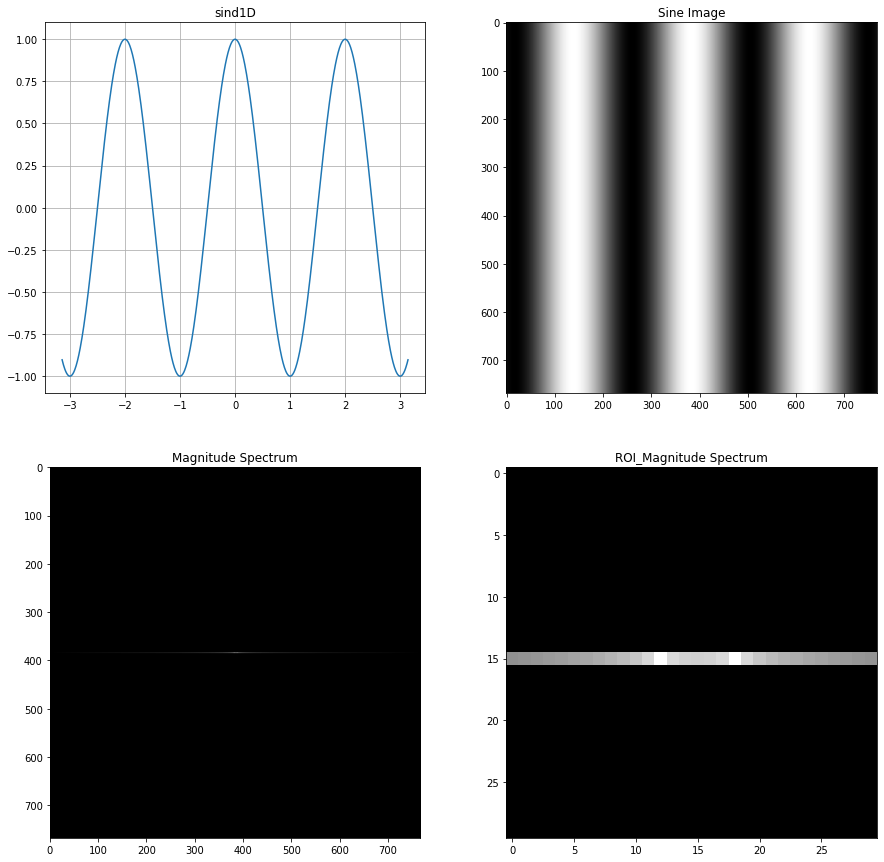

In [7]:
import numpy as np
import matplotlib.pyplot as plt

N = 768 #half 384
x = np.linspace(-np.pi,np.pi, N)

#sine1D = (np.sin(x*np.pi))*1000 #simple noise
sine1D = (np.cos(x*np.pi))*1 #simple noise
#sine1D = 0*x #zero noise
grating = np.tile(sine1D, (N,1))

f= np.fft.fft2(grating)
fshift= np.fft.fftshift(f)
magnitude_spectrum= 20*np.log(np.abs(fshift)+1)
phase= np.angle(fshift)
#########################################################
xx, yy = 369, 369
w, h = 30, 30
ROI = magnitude_spectrum[xx:xx+w, yy:yy+h]
######################################################### 

fig=plt.figure(figsize=(15,15))
plt.subplot(221)
plt.plot(x, sine1D)
plt.grid()
plt.title('sind1D')
plt.subplot(222)
plt.imshow(grating, cmap = 'gray')
plt.title('Sine Image')
plt.subplot(223)
plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Magnitude Spectrum')
plt.subplot(224)
#plt.imshow(phase, cmap ='gray')
#plt.title('Phase Spectrum')
plt.imshow(ROI, cmap = 'gray')
plt.title('ROI_Magnitude Spectrum')

print(sine1D.dtype), print(grating.dtype), print(magnitude_spectrum.dtype)
print(magnitude_spectrum[384, 384]), print(ROI[25,25])
print(np.shape(sine1D)), print(np.shape(grating))

Text(0.5, 1.0, 'ROI')

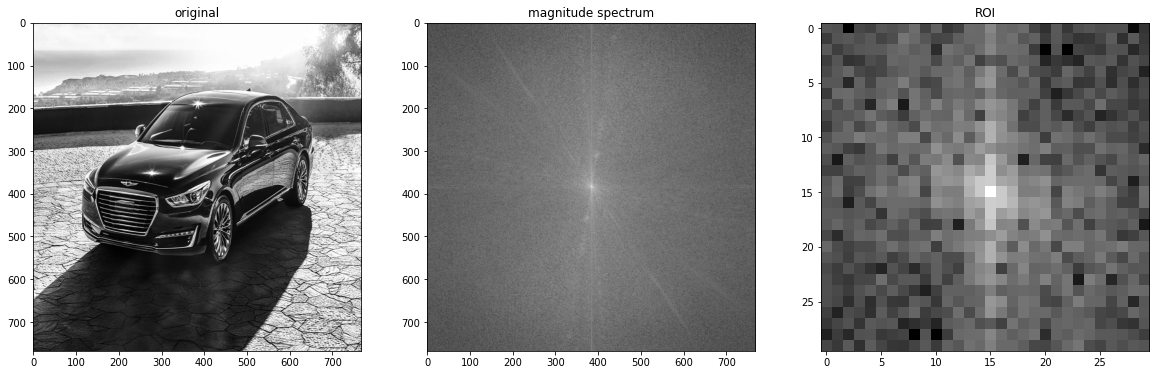

In [8]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import color
from skimage import io

original = color.rgb2gray(io.imread('/content/AP_Test_OPEN/G90_2.jpg'))
original = cv2.resize(original, (768, 768))

f = np.fft.fft2(original)
fshift = np.fft.fftshift(f)
#phase_spectrumR = np.angle(fshift)
magnitude_spectrum = 20*np.log(np.abs(fshift))

x, y = 369, 369 #0~768:x-axis, 0~768:y-axis
w, h = 30, 30

ROI = magnitude_spectrum[x:x+w, y:y+h]

fig = plt.figure(figsize=(20, 15))

plt.subplot(131)
plt.imshow(original, cmap='gray')
plt.title('original')

plt.subplot(132)
plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('magnitude spectrum')

plt.subplot(133)
plt.imshow(ROI, cmap='gray')
plt.title('ROI')


(768, 768)
(768, 768)
float64
float64
float64
float64


(None, None, None, None)

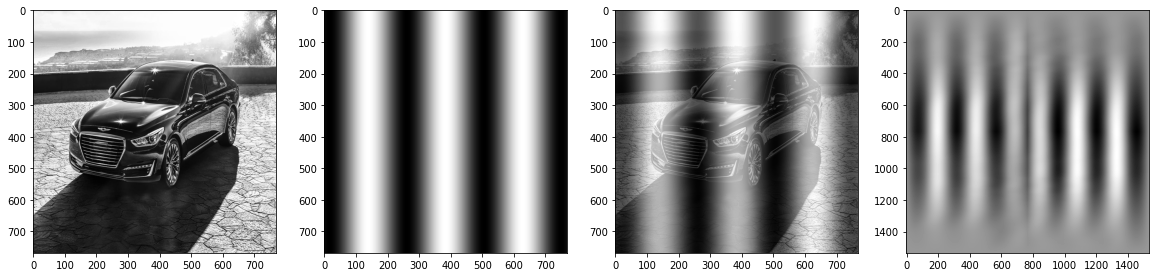

In [10]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import color
from skimage import io
from scipy import signal

original = color.rgb2gray(io.imread('/content/AP_Test_OPEN/G90_2.jpg'))
#original = cv2.imread('/content/AP_Test_OPEN/G90_2.jpg', cv2.IMREAD_COLOR)
original = cv2.resize(original, (768, 768))

print(np.shape(original))
print(np.shape(grating))

noised = cv2.add(original, grating)
noised2 = signal.convolve2d(original, grating) 
#noised2 = original + grating

fig, axs = plt.subplots(1,4, figsize = (20, 5))
axs[0].imshow(original, cmap ='gray')
axs[1].imshow(grating, cmap ='gray')
axs[2].imshow(noised, cmap ='gray')
axs[3].imshow(noised2, cmap ='gray')
plt.show 

print(original.dtype), print(grating.dtype), print(noised.dtype), print(noised2.dtype)

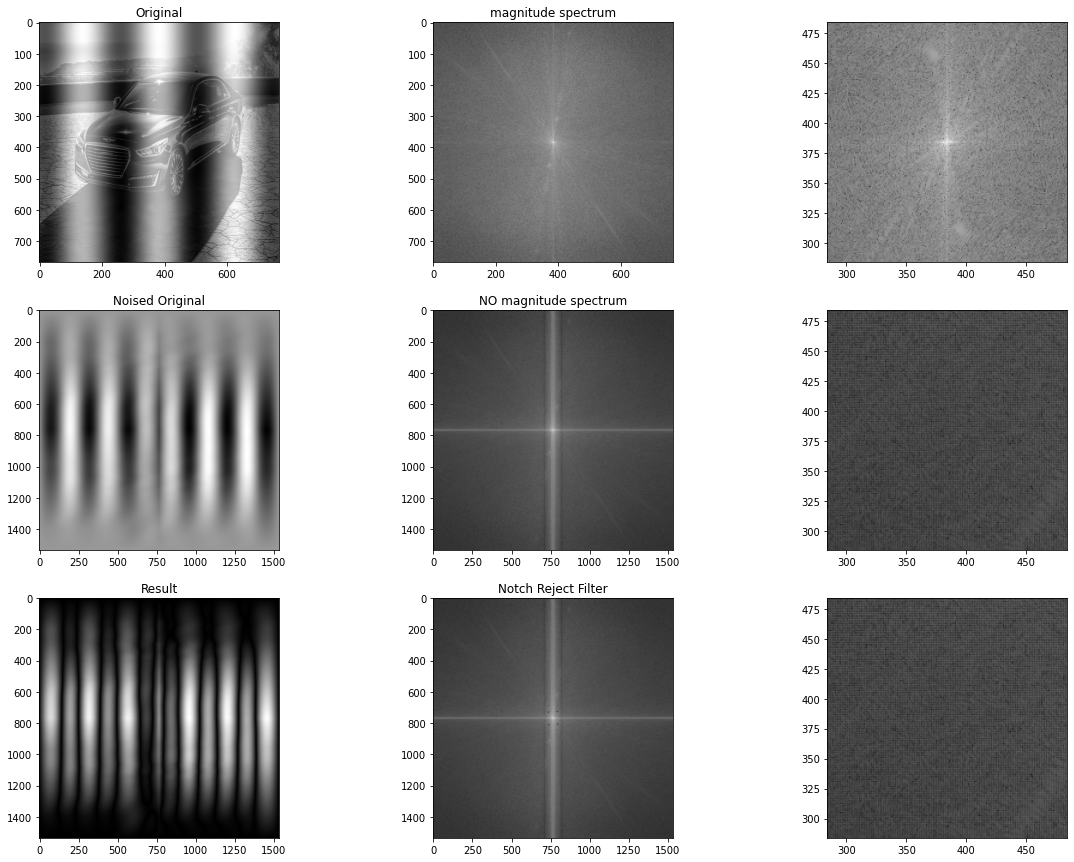

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

#------------------------------------------------------
def notch_reject_filter(shape, d0=9, u_k=0, v_k=0):
    P, Q = shape
    # Initialize filter with zeros
    H = np.zeros((P, Q))

    # Traverse through filter
    for u in range(0, P):
        for v in range(0, Q):
            # Get euclidean distance from point D(u,v) to the center
            D_uv = np.sqrt((u - P / 2 + u_k) ** 2 + (v - Q / 2 + v_k) ** 2)
            D_muv = np.sqrt((u - P / 2 - u_k) ** 2 + (v - Q / 2 - v_k) ** 2)

            if D_uv <= d0 or D_muv <= d0:
                H[u, v] = 0.0
            else:
                H[u, v] = 1.0

    return H
#-----------------------------------------------------
img1 = noised
img2 = noised2

f1 = np.fft.fft2(img1)
fshift1 = np.fft.fftshift(f1)
phase_spectrumR1 = np.angle(fshift1)
magnitude_spectrum1 = 20*np.log(np.abs(fshift1))

f2 = np.fft.fft2(img2)
fshift2 = np.fft.fftshift(f2)
phase_spectrumR2 = np.angle(fshift2)
magnitude_spectrum2 = 20*np.log(np.abs(fshift2))

img_shape = img2.shape

H1 = notch_reject_filter(img_shape, 4, 38, 30)
H2 = notch_reject_filter(img_shape, 4, -42, 27)
H3 = notch_reject_filter(img_shape, 2, 80, 30)
H4 = notch_reject_filter(img_shape, 2, -82, 28)
##################################################

NotchFilter = H1*H2*H3*H4
NotchRejectCenter = fshift2 * NotchFilter 
NotchReject = np.fft.ifftshift(NotchRejectCenter)
inverse_NotchReject = np.fft.ifft2(NotchReject)  # Compute the inverse DFT of the result

Result = np.abs(inverse_NotchReject)

###############################################################################
#x, y = 334, 334 #0~768:x-axis, 0~768:y-axis
#w, h = 50, 50

#ROI1 = magnitude_spectrum1[x:x+w, y:y+h]
#ROI2 = magnitude_spectrum2[x:x+w, y:y+h]
###############################################################################
fig = plt.figure(figsize=(20, 15))

plt.subplot(331)
plt.imshow(img1, cmap='gray')
plt.title('Original')

plt.subplot(332)
plt.imshow(magnitude_spectrum1, cmap='gray')
plt.title('magnitude spectrum')

plt.subplot(333)
plt.imshow(magnitude_spectrum1, cmap='gray')
plt.xlim(384-100, 384+100)
plt.ylim(384-100, 384+100)

plt.subplot(334)
plt.imshow(img2, cmap='gray')
plt.title('Noised Original')

plt.subplot(335)
plt.imshow(magnitude_spectrum2, cmap='gray')
plt.title('NO magnitude spectrum')

plt.subplot(336)
plt.imshow(magnitude_spectrum2, cmap='gray')
plt.xlim(384-100, 384+100)
plt.ylim(384-100, 384+100)

##############################################################################
plt.subplot(337)
plt.imshow(Result, "gray") 
plt.title("Result")

plt.subplot(338)
plt.imshow(magnitude_spectrum2*NotchFilter, "gray") 
plt.title("Notch Reject Filter")

plt.subplot(339)
plt.imshow(magnitude_spectrum2*NotchFilter, cmap='gray')
plt.xlim(384-100, 384+100)
plt.ylim(384-100, 384+100)

plt.show()


GaussLP
ButterworthNR
MButterworthNR


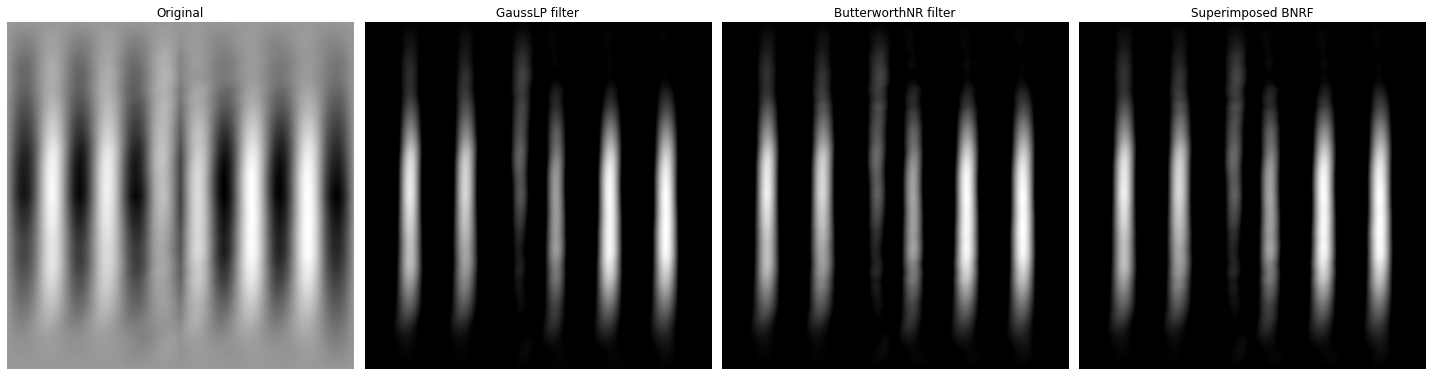

In [14]:
def gaussLowPassFilter(shape, radius=10):  # Gaussian low pass filter
        u, v = np.mgrid[-1:1:2.0 / shape[0], -1:1:2.0 / shape[1]]
        D = np.sqrt(u ** 2 + v ** 2)
        D0 = radius / shape[0]
        kernel = np.exp(- (D ** 2) / (2 * D0 ** 2))
        return kernel

def butterworthNRFilter(shape, radius=9, uk=60, vk=80, n=2):  # Butterworth notch band stop filter
        M, N = shape[1], shape[0]
        u, v = np.meshgrid(np.arange(M), np.arange(N))
        Dm = np.sqrt((u - M // 2 - uk) ** 2 + (v - N // 2 - vk) ** 2)
        Dp = np.sqrt((u - M // 2 + uk) ** 2 + (v - N // 2 + vk) ** 2)
        D0 = radius
        n2 = n * 2
        kernel = (1 / (1 + (D0 / (Dm + 1e-6)) ** n2)) * (1 / (1 + (D0 / (Dp + 1e-6)) ** n2))
        return kernel

def imgFrequencyFilter(img, lpTyper="GaussLP", radius=10):
        normalize = lambda x: (x - x.min()) / (x.max() - x.min() + 1e-8)

        # (1) Edge fill
        imgPad = np.pad(img, ((0, img.shape[0]), (0, img.shape[1])), mode="reflect")
        # (2) Centralization: F (x, y) * - 1 ^ (x + y)
        mask = np.ones(imgPad.shape)
        mask[1::2, ::2] = -1
        mask[::2, 1::2] = -1
        imgPadCen = imgPad * mask
        # (3) Fourier transform
        fft = np.fft.fft2(imgPadCen)

        # (4) Construct the frequency domain filter transfer function:
        if lpTyper == "GaussLP":
            print(lpTyper)
            freFilter = gaussLowPassFilter(imgPad.shape, radius=60)
        elif lpTyper == "GaussHP":
            freFilter = gaussLowPassFilter(imgPad.shape, radius=60)
        elif lpTyper == "ButterworthNR":
            print(lpTyper)
            freFilter = butterworthNRFilter(imgPad.shape, radius=9, uk=60, vk=80, n=2)  # Butterworth notch band stop filter
        elif lpTyper == "MButterworthNR":
            print(lpTyper)
            BNRF1 = butterworthNRFilter(imgPad.shape, radius=9, uk=60, vk=80, n=2)  # Butterworth notch band stop filter
            BNRF2 = butterworthNRFilter(imgPad.shape, radius=9, uk=-60, vk=80, n=2)
            BNRF3 = butterworthNRFilter(imgPad.shape, radius=9, uk=60, vk=160, n=2)
            BNRF4 = butterworthNRFilter(imgPad.shape, radius=9, uk=-60, vk=160, n=2)
            freFilter = BNRF1 * BNRF2 * BNRF3 * BNRF4
        else:
            print("Error of unknown filter")
            return -1

        # (5) Modify Fourier transform in frequency domain: Fourier transform point multiplication filter transfer function
        freTrans = fft * freFilter
        # (6) Inverse Fourier transform
        ifft = np.fft.ifft2(freTrans)
        # (7) Decentralized inverse transform image
        M, N = img.shape[:2]
        mask2 = np.ones(imgPad.shape)
        mask2[1::2, ::2] = -1
        mask2[::2, 1::2] = -1
        ifftCenPad = ifft.real * mask2
        # (8) Intercept the upper left corner, the size is equal to the input image
        imgFilter = ifftCenPad[:M, :N]
        imgFilter = np.clip(imgFilter, 0, imgFilter.max())
        imgFilter = np.uint8(normalize(imgFilter) * 255)
        return imgFilter

# Using notch filtering to delete moire patterns in digital printed images
# (1) Read original image
img1 = img2 #cv2.imread("../images/Fig0464a.tif", flags=0)  # flags=0 read as grayscale image
fig = plt.figure(figsize=(20, 15))
plt.subplot(141), plt.title("Original"), plt.axis('off'), plt.imshow(img2, cmap='gray')

# (2) Image Gaussian low pass filtering
imgGLPF = imgFrequencyFilter(img2, lpTyper="GaussLP", radius=30)  # Image Gaussian low pass filtering
plt.subplot(142), plt.title("GaussLP filter"), plt.axis('off'), plt.imshow(imgGLPF, cmap='gray')

# (3) Image Butterworth notch band stop filtering
imgBNRF = imgFrequencyFilter(img2, lpTyper="ButterworthNR", radius=9)
plt.subplot(143), plt.title("ButterworthNR filter"), plt.axis('off'), plt.imshow(imgBNRF, cmap='gray')

# (4) Superimposed Butterworth notch band stop filtering
imgSBNRF = imgFrequencyFilter(img2, lpTyper="MButterworthNR", radius=9)
plt.subplot(144), plt.title("Superimposed BNRF"), plt.axis('off'), plt.imshow(imgSBNRF, cmap='gray')

plt.tight_layout()
plt.show()
